1. Import


In [201]:
import pandas as pd
import numpy as np
import pickle
import yaml
import sys
import warnings
from pathlib import Path
from typing import List, Dict, Any, Tuple

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches 
import matplotlib.ticker as mtick

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

2. Analysis Settings


In [202]:
CONFIG_PATH = "../configs/movielens_1m.yaml" 
config_path = Path(CONFIG_PATH)
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

DATASET_NAME = config['dataset_name']
SAVE_DIR = Path("../results") 
MODEL_NAMES = config['models']
METRIC_NAMES = ["NDCG@10", "Recall@10", "Precision@10", "MRR@10", "Novelty", "CatalogCoverage", "APLT", "ACLT", "CompositeDiv"]
BASELINE_MODE = 'None'
PERSONALIZATION_MODES = ["P", "NP"]
TODAY_DATE = pd.Timestamp.now().strftime("%Y%m%d")
# TODAY_DATE = "20251112"
SWEEP_CSV_PATH = SAVE_DIR / DATASET_NAME / f"{TODAY_DATE}_{DATASET_NAME}_parameter_sweep_results.csv"

print(f"데이터셋 분석 시작: {DATASET_NAME}")

데이터셋 분석 시작: movielens_1m


3. Helper Functions


In [203]:
def calculate_axis_limits(
    df: pd.DataFrame, 
    model_names: List[str], 
    metric_names: List[str], 
    baseline_mode: str = 'None'
) -> Dict[str, Dict[str, Tuple[float, float]]]:
    df_for_limits = df[df['diversification'] != baseline_mode].copy()
    
    limits_per_model = {}

    for model_name in model_names:
        model_df = df_for_limits[df_for_limits['model'] == model_name]
        if model_df.empty:
            continue
            
        limits_per_metric = {}
        for metric in metric_names:
            if metric not in model_df.columns:
                continue
            
            data_min = model_df[metric].min()
            data_max = model_df[metric].max()

            if pd.isna(data_min) or pd.isna(data_max) or data_min == data_max:
                data_min = data_min * 0.9 if data_min > 0 else data_min * 1.1
                data_max = data_max * 1.1 if data_max > 0 else data_max * 0.9
                # 0일 경우 대비
                if data_min == 0 and data_max == 0:
                    data_min, data_max = -0.01, 0.01

            data_range = data_max - data_min
            padding = data_range * 0.10
            
            plot_min = data_min - padding
            plot_max = data_max + padding
            
            limits_per_metric[metric] = (plot_min, plot_max)
            
        limits_per_model[model_name] = limits_per_metric
        
    print("--- ✅ Y축 범위 계산 완료 ---")
    return limits_per_model

def plot_sensitivity_results(
    df: pd.DataFrame, 
    model_names: List[str], 
    metric_names: List[str],
    dataset_name: str,
    ndcg_metric_name: str,
    composite_div_metric_name: str,
    axis_limits: Dict[str, Dict[str, Tuple[float, float]]],
    baseline_mode: str = 'None',
    personalize_mode: str = 'P'
):
    
    df_cleaned = df.copy() 
    all_numeric_cols = list(set(metric_names + [ndcg_metric_name, composite_div_metric_name, 'lambda_param']))
    
    for col in all_numeric_cols:
        if col in df_cleaned.columns:
            df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')
        else:
            if col in [ndcg_metric_name, composite_div_metric_name]:
                print(f"경고: Ratio 계산용 '{col}' 컬럼이 DataFrame에 없음")
            elif col in metric_names:
                print(f"경고: '{col}' 컬럼이 DataFrame에 없음 ")

    df_cleaned['diversification'] = df_cleaned['diversification'].fillna(baseline_mode).astype(str)
    df_cleaned['personalize'] = df_cleaned['personalize'].astype(str)
    df_cleaned['model'] = df_cleaned['model'].astype(str)
    
    BASELINE_SOURCE_MODE = 'NP' 

    df_filtered = df_cleaned[
        (df_cleaned['personalize'] == personalize_mode) |  
        (df_cleaned['diversification'] == baseline_mode)
    ]
    
    all_metrics_for_baseline = list(set(metric_names + [ndcg_metric_name, composite_div_metric_name]))
    
    baseline_df = df_filtered[
        (df_filtered['diversification'] == baseline_mode) &
        (df_filtered['personalize'] == BASELINE_SOURCE_MODE) 
    ].groupby('model')[all_metrics_for_baseline].mean()

    unique_div_modes = sorted([
        m for m in df_filtered['diversification'].unique() if m != baseline_mode
    ])
    
    palette = sns.color_palette("viridis", n_colors=len(unique_div_modes))
    div_mode_color_map = dict(zip(unique_div_modes, palette))
    
    legend_handles = [mpatches.Patch(color=div_mode_color_map[mode], label=f"{mode} ({personalize_mode})")
                      for mode in unique_div_modes]
    if not baseline_df.empty:
         legend_handles.append(plt.Line2D([0], [0], color='red', linestyle='--', label=f"{baseline_mode} ({personalize_mode})"))
    
    print("\n--- 📊 람다(Lambda) 민감도 플로팅 시작 ---")

    for model_name in model_names:
        model_df = df_filtered[df_filtered['model'] == model_name]
        if model_df.empty:
            continue
            
        print(f"모델 {model_name} ({personalize_mode} 모드) 플로팅")

        fig, axes = plt.subplots(2, 5, figsize=(20, 9), constrained_layout=False) 
        fig.suptitle(f'Model Parameter Sensitivity: {model_name}', fontsize=20)
        axes = axes.flatten()

        baseline_exists = model_name in baseline_df.index
        model_limits = axis_limits.get(model_name, {})

        for i, metric in enumerate(metric_names):
            ax = axes[i]
            plot_data = model_df[model_df['diversification'] != baseline_mode]
            
            if plot_data.empty or metric not in plot_data.columns:
                ax.set_title(f"{metric}\n(데이터 없음)", fontsize=14); ax.axis('off'); continue

            baseline_value = baseline_df.loc[model_name, metric] if baseline_exists else None

            sns.lineplot(
                data=plot_data, x='lambda_param', y=metric, hue='diversification',
                ax=ax, marker='o', palette=div_mode_color_map, 
                hue_order=unique_div_modes, legend=False 
            )

            if baseline_value is not None:
                ax.axhline(y=baseline_value, color='red', linestyle='--', label=baseline_mode)

            ax.set_title(metric, fontsize=14)
            ax.set_xlabel('Relevanve (λ_rel)', fontsize=12)
            ax.set_ylabel('Score', fontsize=12)
            ax.grid(True, linestyle='--')
            ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
            if metric in model_limits:
                plot_min, plot_max = model_limits[metric]
                ax.set_ylim(plot_min, plot_max)

        ax_tradeoff = axes[9]
        
        baseline_ndcg_val = baseline_df.loc[model_name, ndcg_metric_name] if baseline_exists and ndcg_metric_name in baseline_df.columns else None
        baseline_div_val = baseline_df.loc[model_name, composite_div_metric_name] if baseline_exists and composite_div_metric_name in baseline_df.columns else None

        if (baseline_ndcg_val is not None) and (baseline_div_val is not None):
            plot_data_tradeoff = model_df[model_df['diversification'] != baseline_mode].copy()
            
            plot_data_tradeoff['CompositeDiv_Gain'] = plot_data_tradeoff[composite_div_metric_name] - baseline_div_val
            plot_data_tradeoff['NDCG_Loss'] = baseline_ndcg_val - plot_data_tradeoff[ndcg_metric_name]
            
            plot_data_tradeoff['Tradeoff_Ratio'] = plot_data_tradeoff['CompositeDiv_Gain'] / plot_data_tradeoff['NDCG_Loss']
            plot_data_tradeoff.replace([np.inf, -np.inf], np.nan, inplace=True)
            
            if plot_data_tradeoff.empty or plot_data_tradeoff['Tradeoff_Ratio'].isnull().all():
                ax_tradeoff.set_title(f"Tradeoff_Ratio\n(계산 실패/데이터 없음)", fontsize=14)
                ax_tradeoff.axis('off')
            else:
                sns.lineplot(
                    data=plot_data_tradeoff, 
                    x='lambda_param', 
                    y='Tradeoff_Ratio', 
                    hue='diversification',
                    ax=ax_tradeoff, 
                    marker='o',
                    palette=div_mode_color_map, 
                    hue_order=unique_div_modes,
                    legend=False 
                )
                
                ax_tradeoff.axhline(y=1.0, color='blue', linestyle=':', label='이득 = 손실 (비율=1)')
                ax_tradeoff.axhline(y=0.0, color='grey', linestyle=':', label='이득 = 0 (비율=0)')
                ax_tradeoff.set_title('Tradeoff Ratio', fontsize=14)
                ax_tradeoff.set_xlabel('Relevanve (λ_rel)', fontsize=12)
                ax_tradeoff.set_ylabel('Ratio', fontsize=12) 
                
                ax_tradeoff.grid(True, linestyle='--')
                ax_tradeoff.set_ylim(-100.0, 100.0)
        else:
            ax_tradeoff.set_title(f"Tradeoff_Ratio\n(베이스라인 없음)", fontsize=14)
            ax_tradeoff.axis('off')

        fig.legend(handles=legend_handles,
                   loc='lower center', bbox_to_anchor=(0.5, -0.01),
                   ncol=len(unique_div_modes) + 1,
                   title=f'Personalize Mode ({personalize_mode})', fontsize=12)
        
        dataset_save_path = SAVE_DIR / DATASET_NAME / dataset_name
        dataset_save_path.mkdir(parents=True, exist_ok=True) 
        output_path = dataset_save_path / f"{TODAY_DATE}_{dataset_name}_{model_name}_{personalize_mode}_sensitivity_plot.png"
        
        try:
            plt.tight_layout(rect=[0, 0.05, 1, 0.95]) 
            fig.savefig(output_path, bbox_inches='tight')
            print(f"플롯 저장 완료: {output_path.name}")
            plt.show()
        except Exception as e:
            print(f"플롯 저장/표시 중 오류 발생: {e}")
            
        plt.close(fig)

4. Analysis


--- ✅ Y축 범위 계산 완료 ---

--- 📊 람다(Lambda) 민감도 플로팅 시작 ---
모델 WMF (P 모드) 플로팅
플롯 저장 완료: 20251113_movielens_1m_WMF_P_sensitivity_plot.png


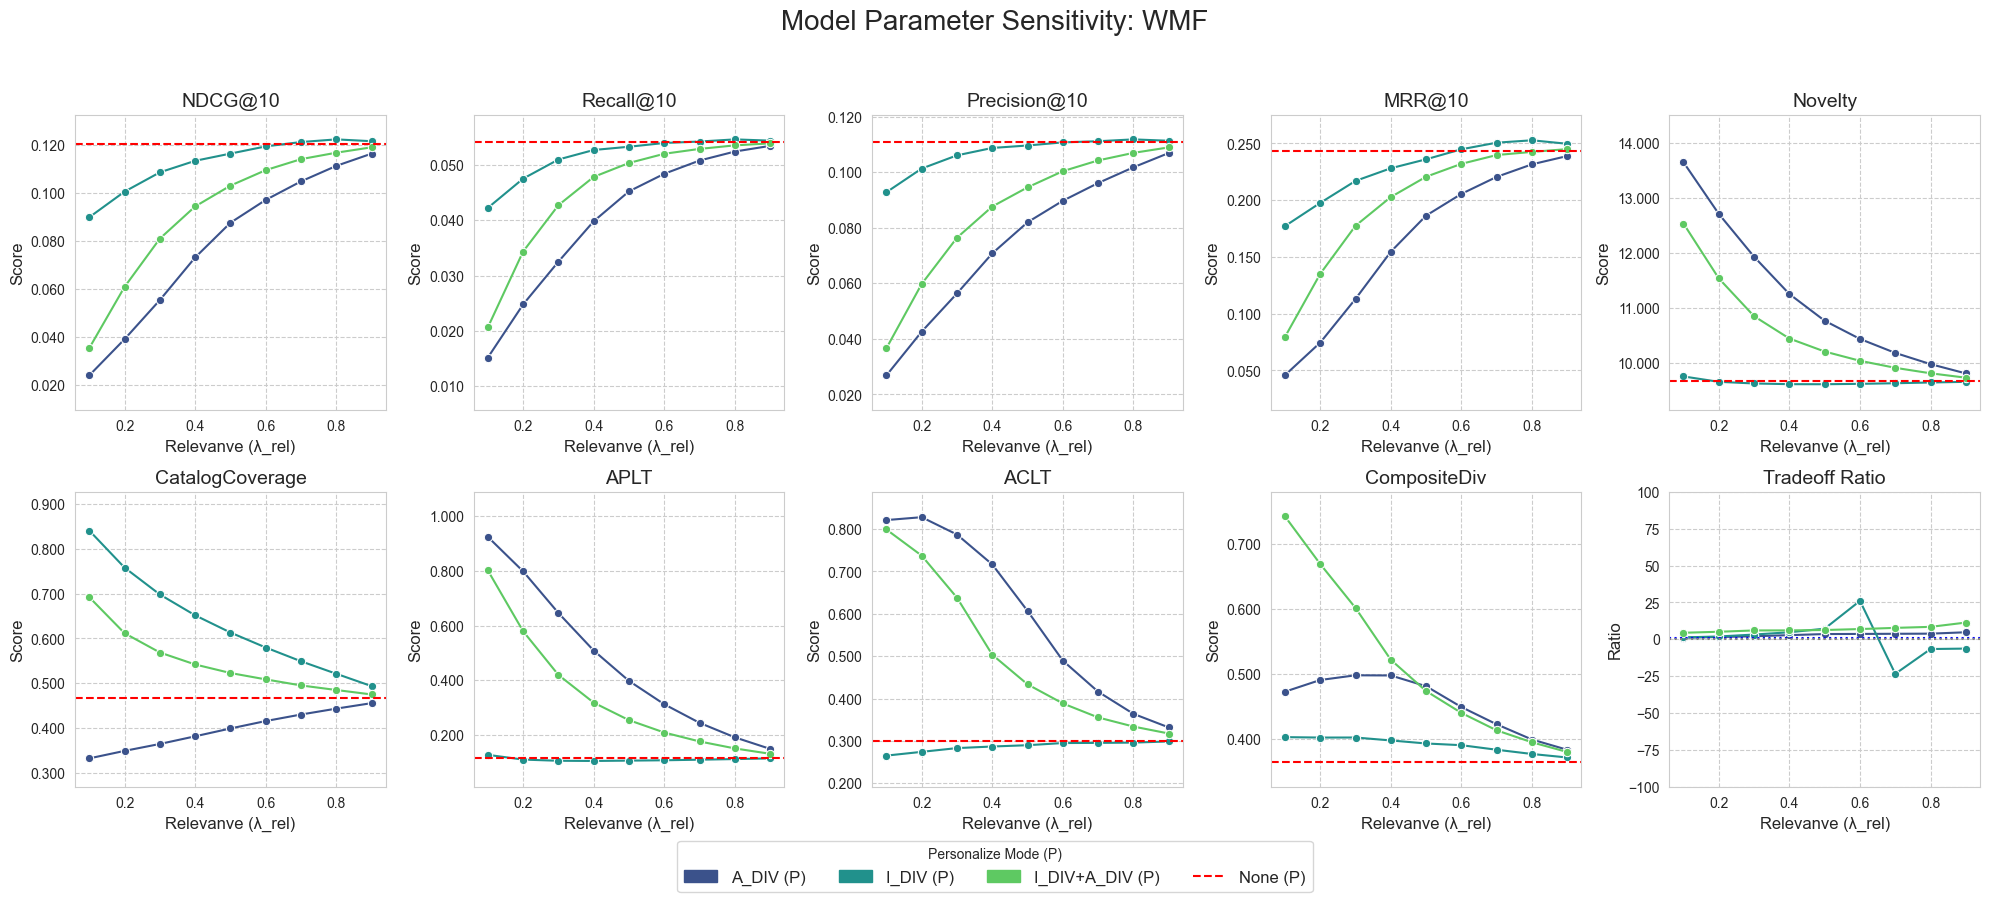

모델 EASEᴿ (P 모드) 플로팅
플롯 저장 완료: 20251113_movielens_1m_EASEᴿ_P_sensitivity_plot.png


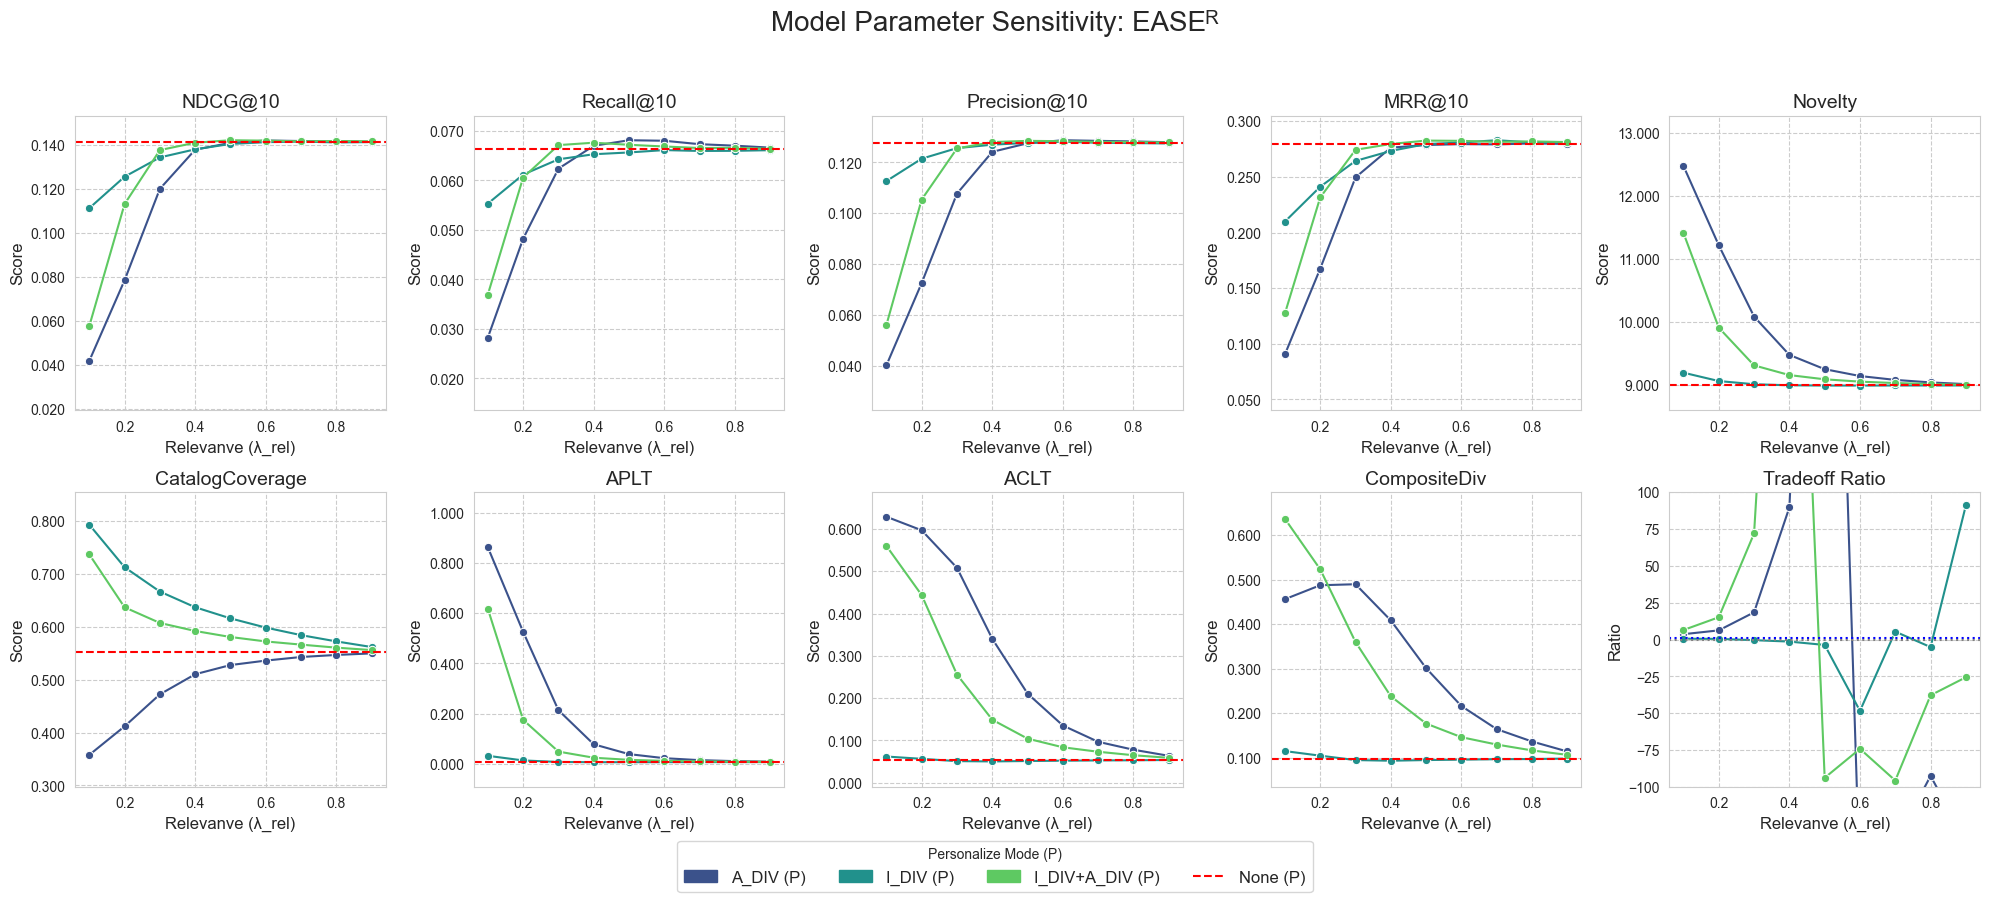

모델 VAECF (P 모드) 플로팅
플롯 저장 완료: 20251113_movielens_1m_VAECF_P_sensitivity_plot.png


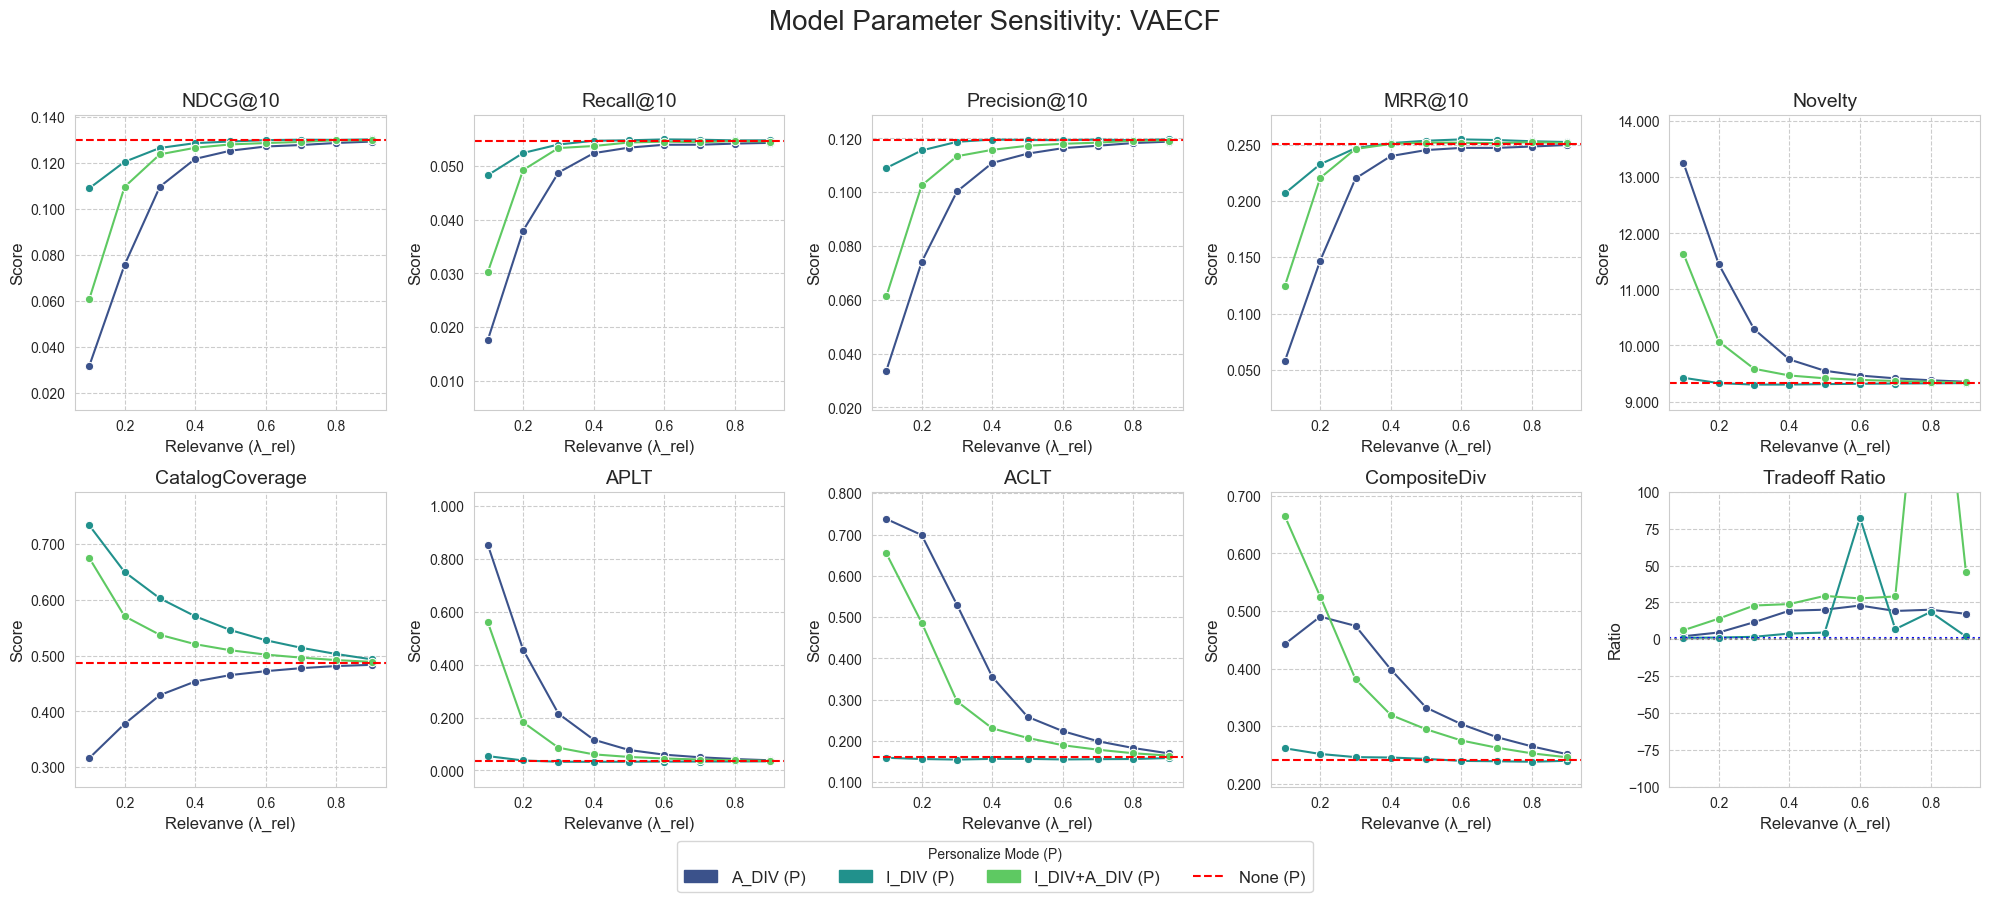

모델 NeuMF (P 모드) 플로팅
플롯 저장 완료: 20251113_movielens_1m_NeuMF_P_sensitivity_plot.png


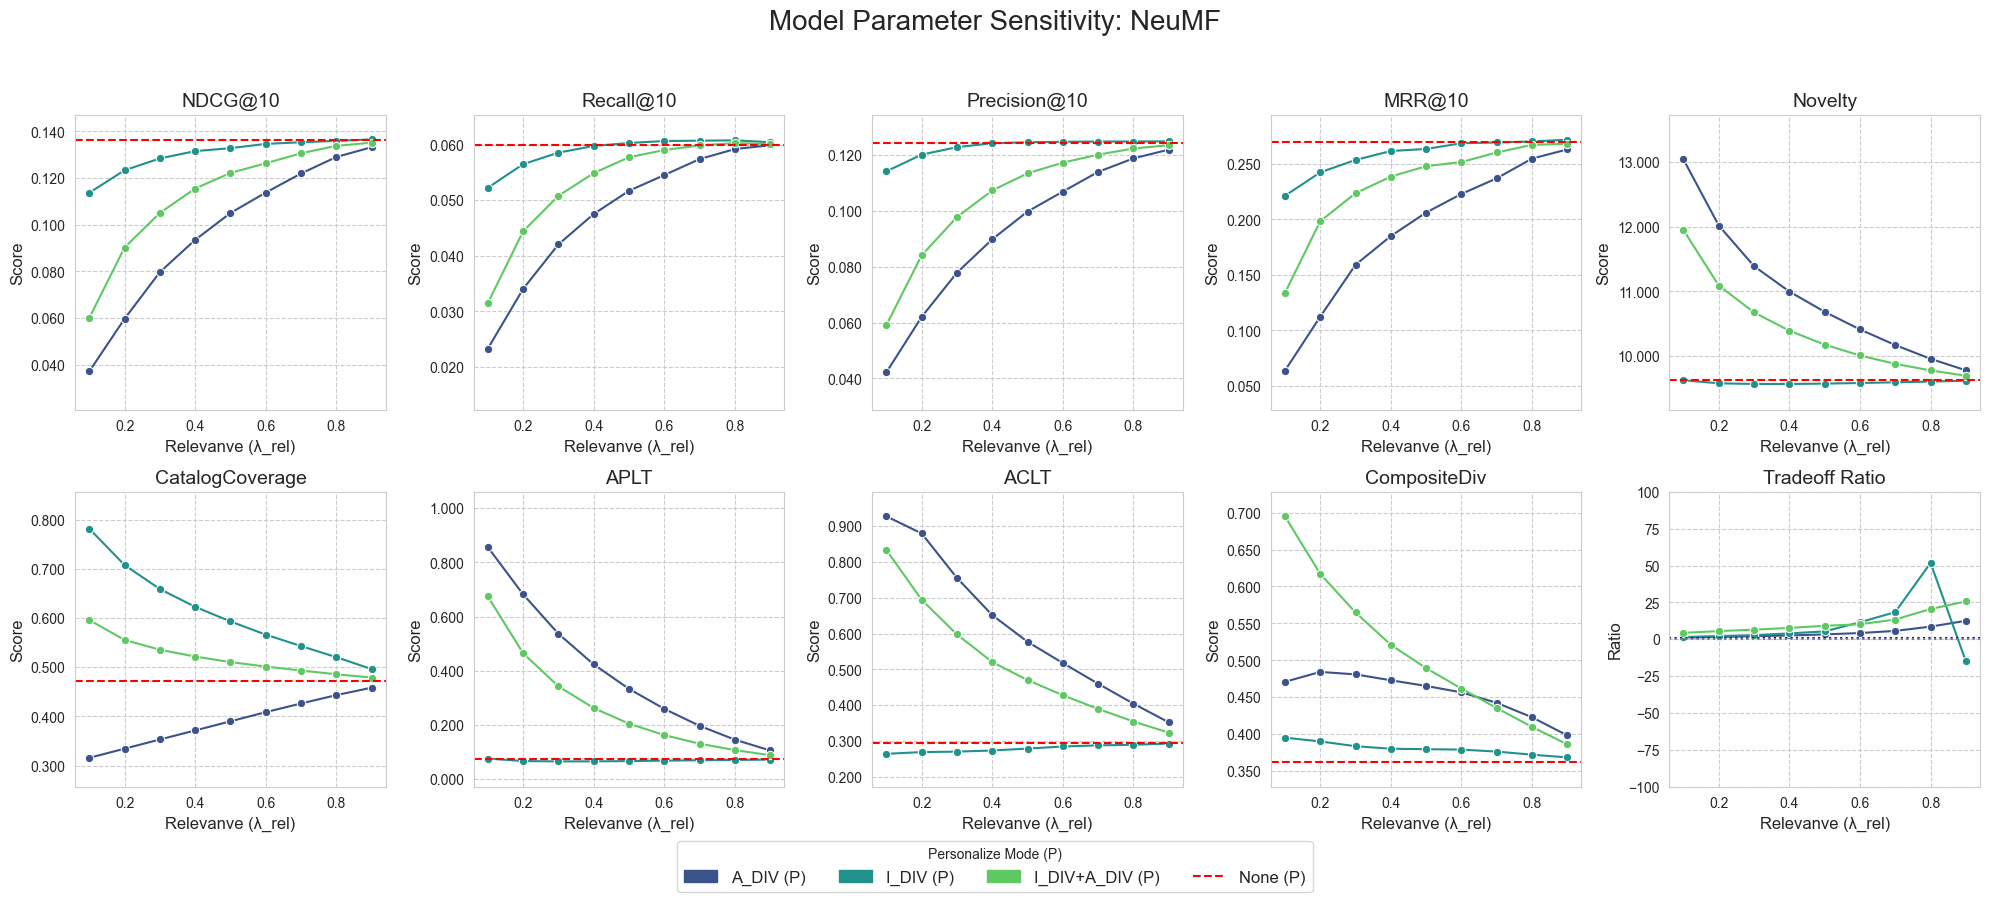


--- 📊 람다(Lambda) 민감도 플로팅 시작 ---
모델 WMF (NP 모드) 플로팅
플롯 저장 완료: 20251113_movielens_1m_WMF_NP_sensitivity_plot.png


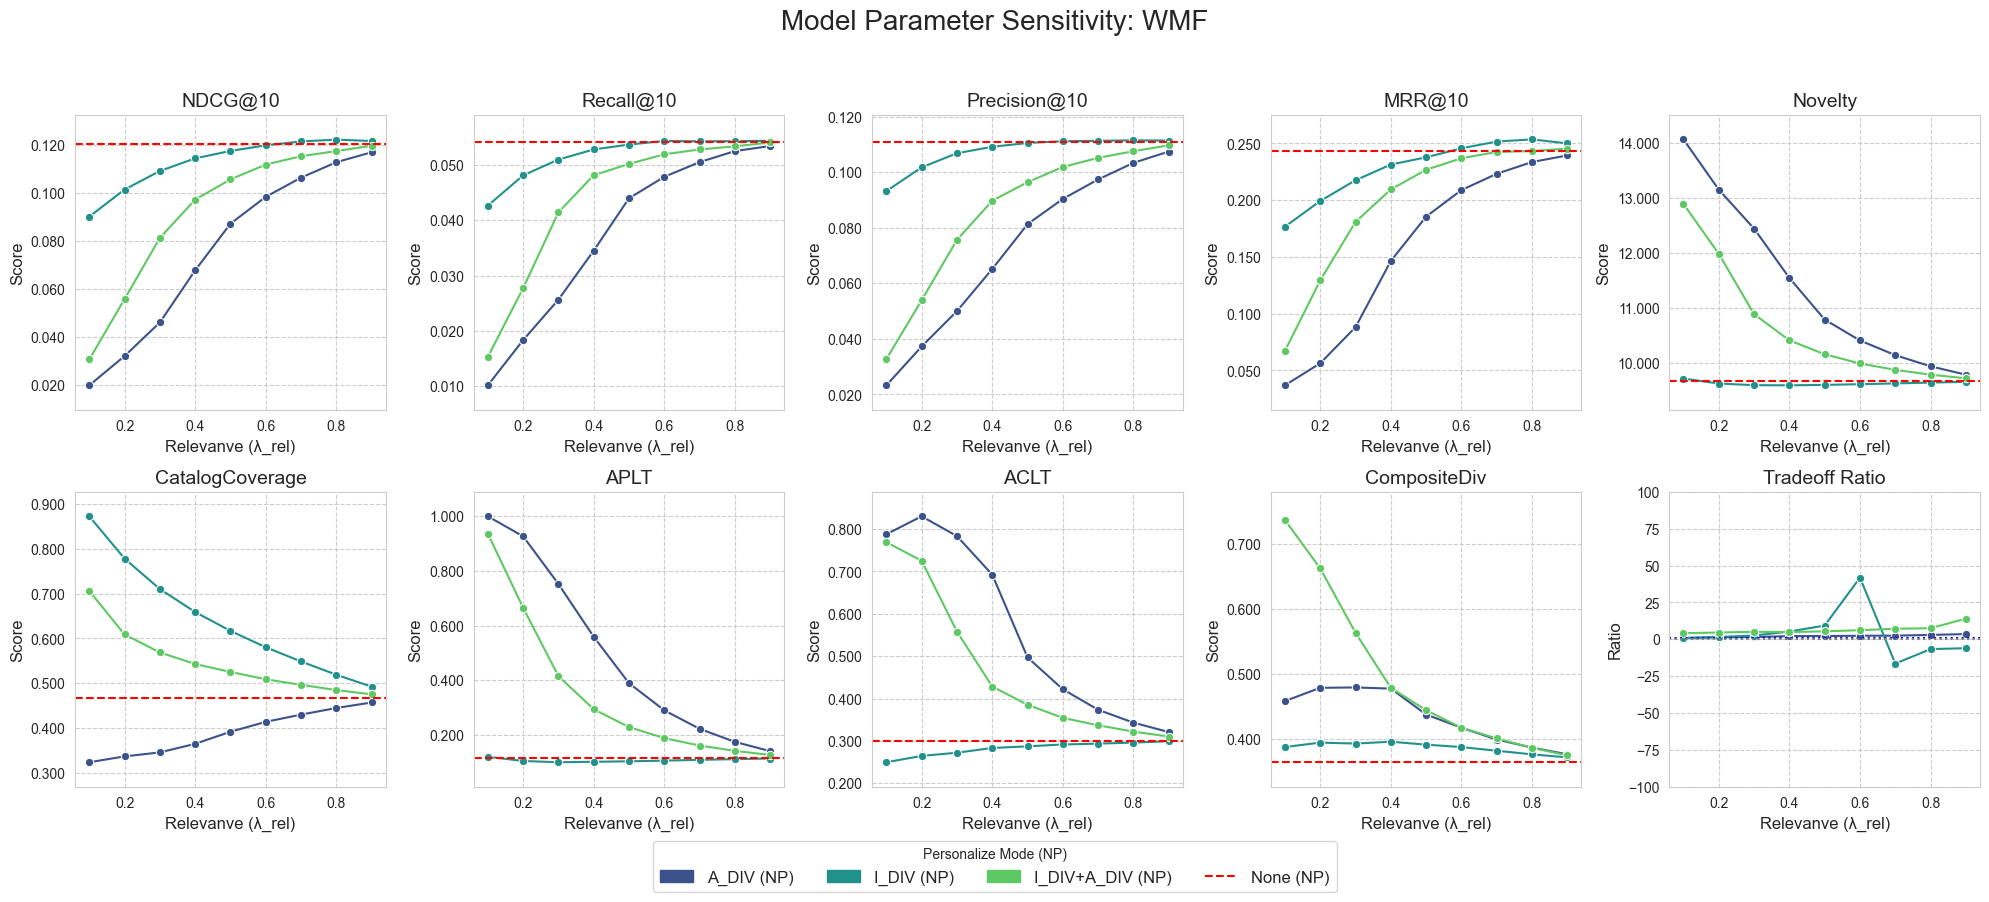

모델 EASEᴿ (NP 모드) 플로팅
플롯 저장 완료: 20251113_movielens_1m_EASEᴿ_NP_sensitivity_plot.png


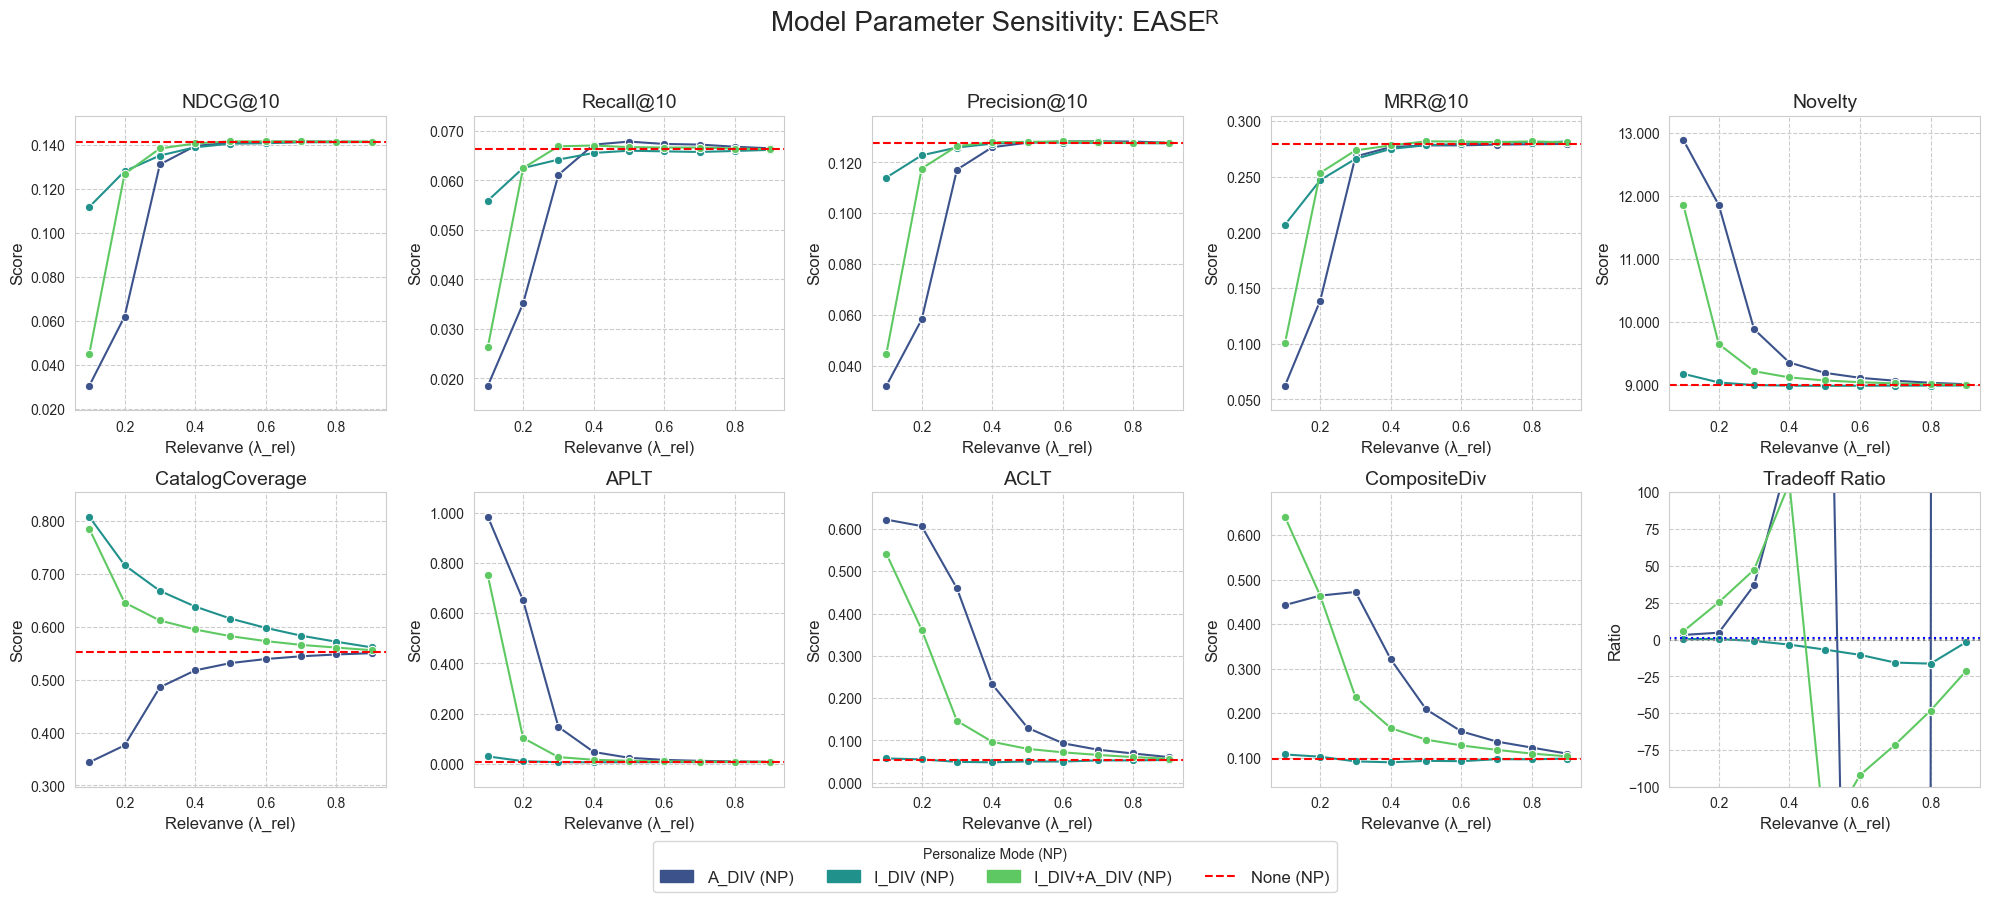

모델 VAECF (NP 모드) 플로팅
플롯 저장 완료: 20251113_movielens_1m_VAECF_NP_sensitivity_plot.png


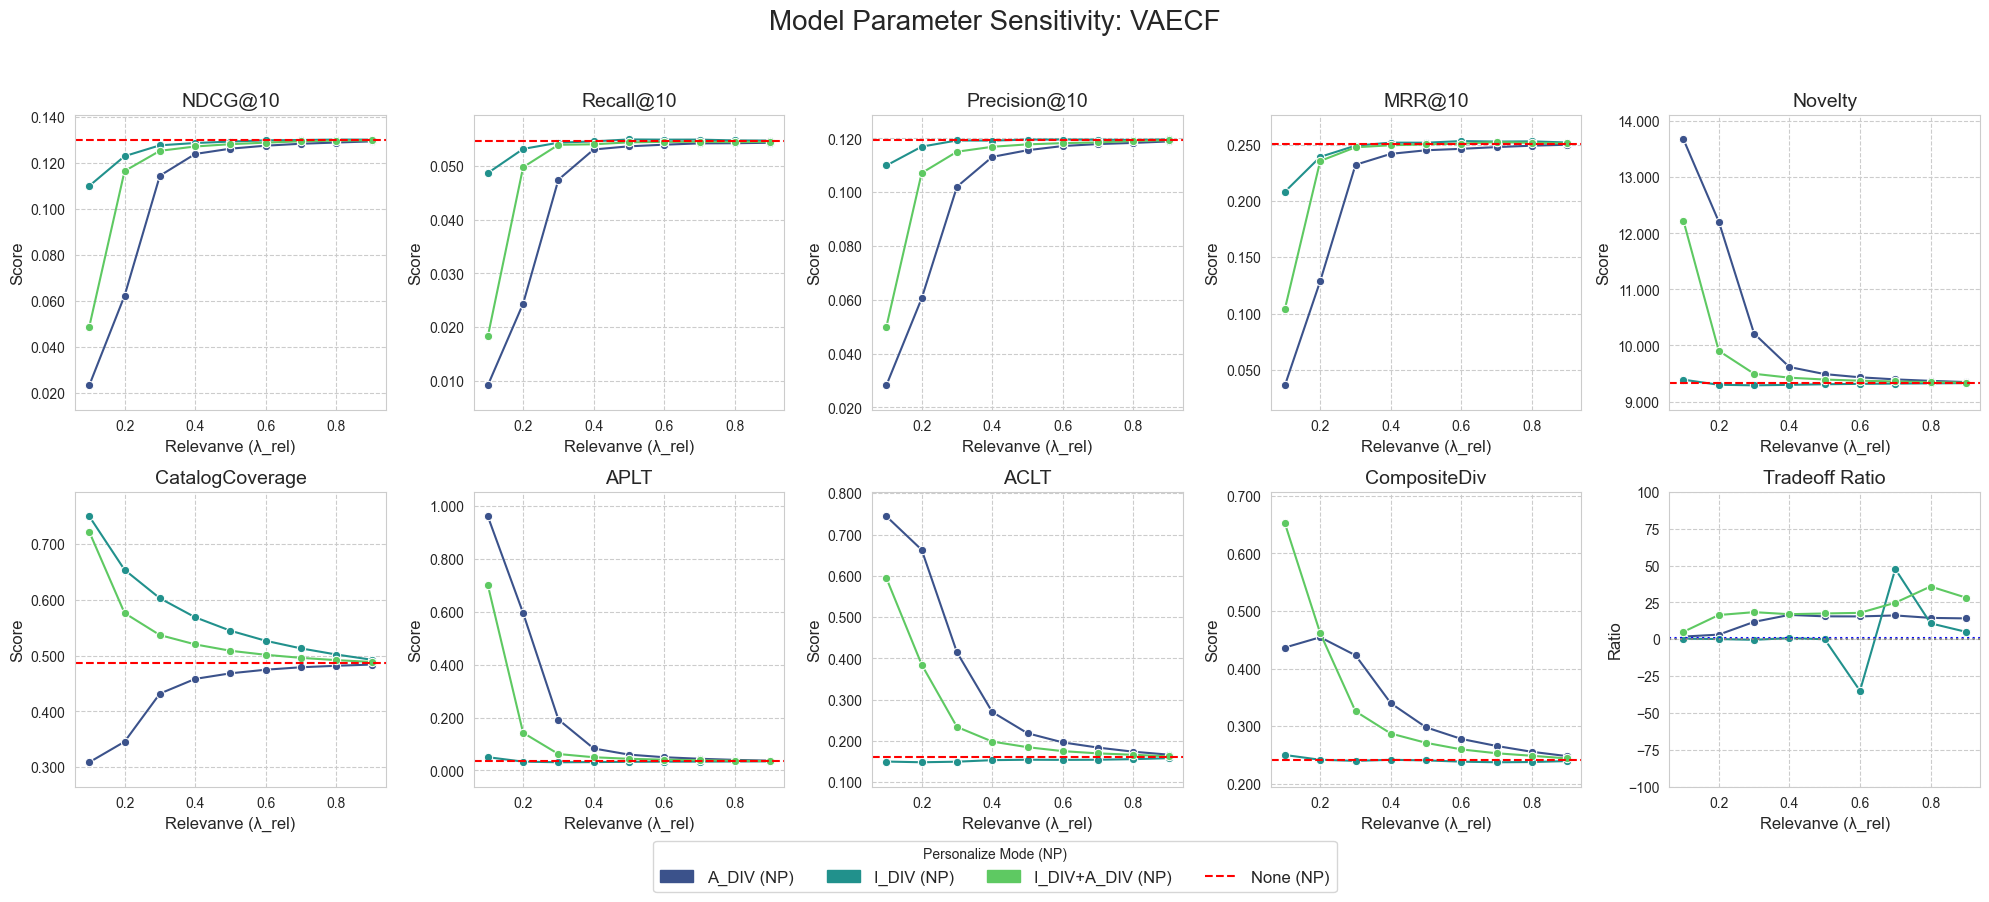

모델 NeuMF (NP 모드) 플로팅
플롯 저장 완료: 20251113_movielens_1m_NeuMF_NP_sensitivity_plot.png


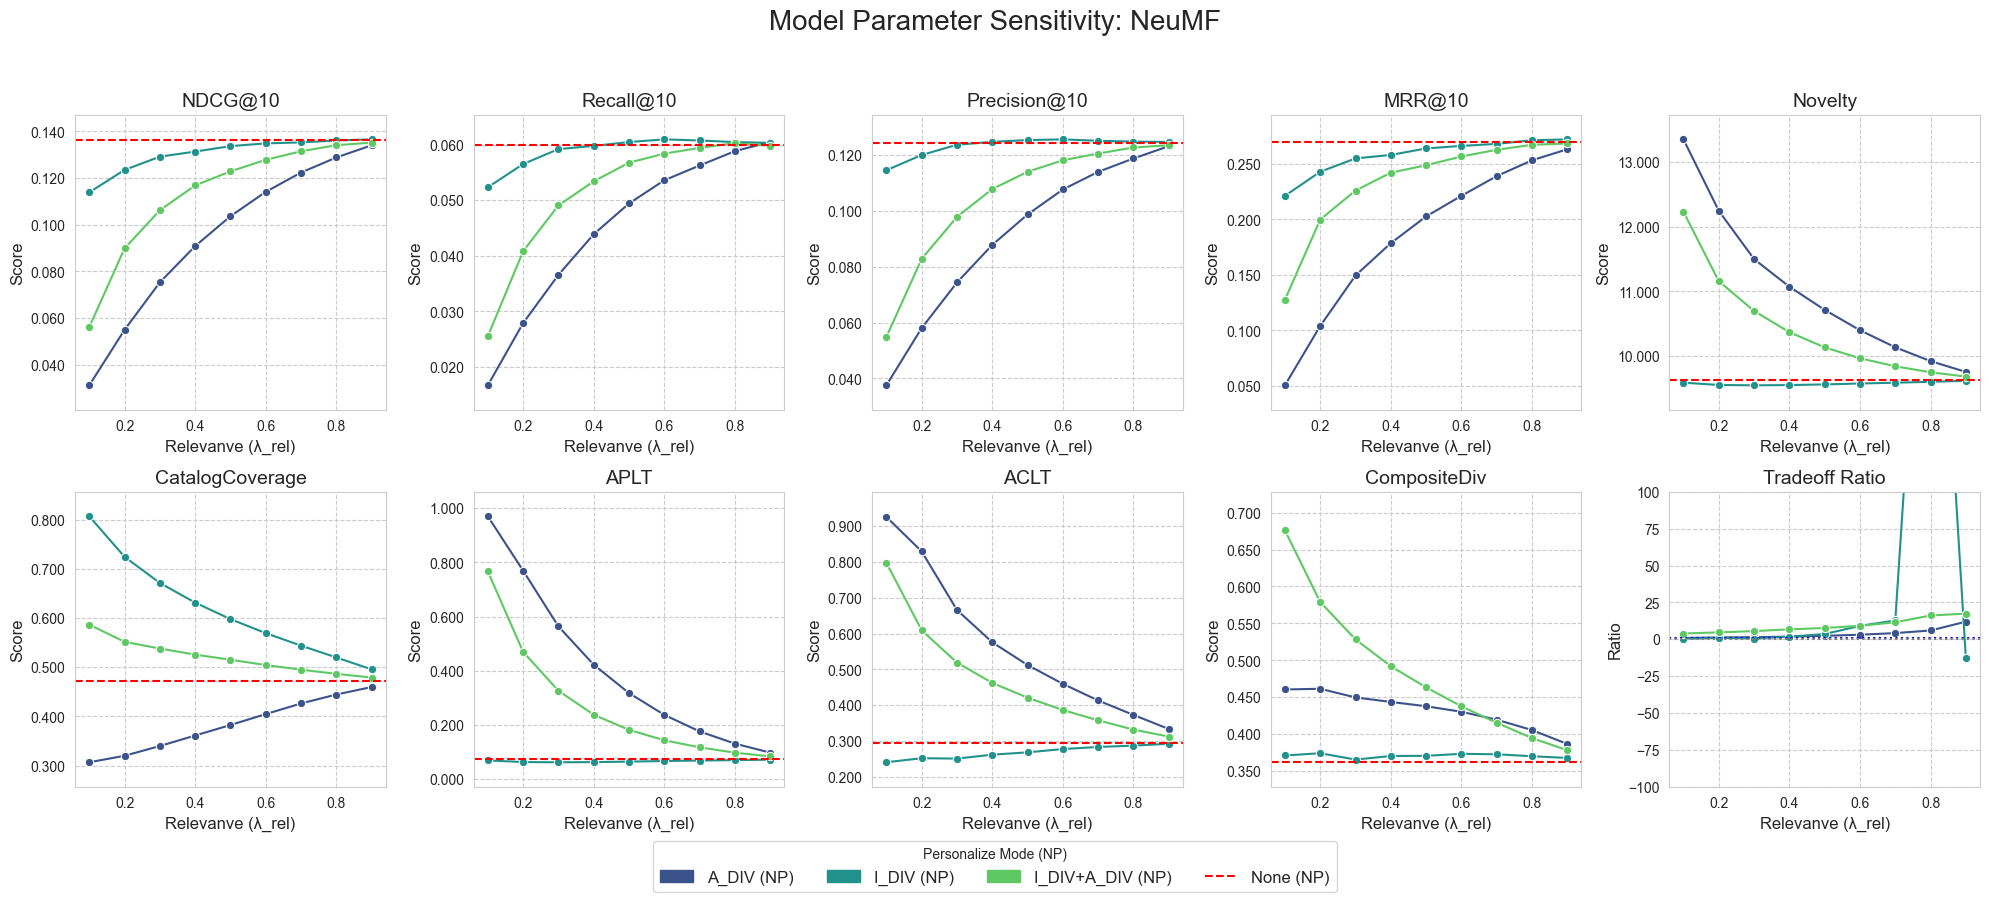

In [204]:
try:
    sweep_results_df = pd.read_csv(SWEEP_CSV_PATH)

    axis_limits = calculate_axis_limits(
        df=sweep_results_df, 
        model_names=MODEL_NAMES, 
        metric_names=METRIC_NAMES,
        baseline_mode=BASELINE_MODE
    )

    for p_mode in PERSONALIZATION_MODES:
        plot_sensitivity_results(
            sweep_results_df, 
            model_names=MODEL_NAMES,
            metric_names=METRIC_NAMES,
            dataset_name=DATASET_NAME,
            ndcg_metric_name='NDCG@10',
            composite_div_metric_name='CompositeDiv',
            baseline_mode=BASELINE_MODE,
            personalize_mode=p_mode,
            axis_limits=axis_limits
        )
except FileNotFoundError:
    print(f"🚨 에러: CSV 파일 찾지 못함 {SWEEP_CSV_PATH}")
except Exception as e:
    print(f"에러: {e}")